# Recurrent Neural Network (RNN)

This implmenation of the RNN is inspired from Karparty's cs231n Lecture [model](https://gist.github.com/karpathy/d4dee566867f8291f086). This RNN is adapted for character level language model which generates names (makemore) project model.

**Note:**
We are pytorchifying the numpy version in this notebook


In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures

%matplotlib inline

## Load Data

In [8]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [9]:
print(f"{len(words)=}")

len(words)=32033


## Helpers

In [10]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


## Build Dataset

In [11]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      context = context[1:] + [ix] # crop and append
      Y.append(context)  # Y's are 1 shifted from X 

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625, 3])
torch.Size([22655, 3]) torch.Size([22655, 3])
torch.Size([22866, 3]) torch.Size([22866, 3])


## Model

A RNN Model consists of three layers. 
1. Input Layer
2. Hidden Layer
3. Output layer

Mathematical formulation of a RNN Cell(neuron is) 
$$ h_t = tanh(W_{hh}h_{t-1} + W_{xh}x_t)$$
$$ y_t = W_{hy}h_t$$

Here,
- $x_t$ is input at time-step *t*
- $h_t$ is hidden state at time *t-1*
- $y_t$ is output at time *t*
- $W_{hh}, W_{xh}, W_{hy}$ is weigth matrices (parameteres learned by the network)

In [76]:
# RNN
# hyper-parameters
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
seq_len = block_size # number of steps to unroll the RNN for

# model parameters
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),          generator=g)  # embedding look-up table
Wxh = torch.randn((n_embd, n_hidden),           generator=g) * 0.01 # Input to hidden weights
Whh = torch.randn((n_hidden, n_hidden),         generator=g) * 0.01 # Hidden layer
Why = torch.randn((n_hidden, vocab_size),       generator=g) * 0.01 # Hideen to output
bh = torch.zeros(n_hidden)  # hidden bias
by = torch.zeros(vocab_size)  # output bias


parameters = [C, Wxh, Whh, Why, bh, by]

print(f"Total parameters:{(sum(p.nelement() for p in parameters))}")
# for p in parameters:
#     p.requires_grad = True

Total parameters:14097


### Manual Implementation of Forward and Backprop

In [78]:
# training loop
max_steps = 200_000
batch_size = 32
n = batch_size

hprev = torch.zeros(n_hidden).expand(batch_size, -1) # initialize hidden state to zero
lossi = []
with torch.no_grad():
    for i in range(max_steps):
        # construct minibatch
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]
        
        # forward pass
        loss = 0 # initialize loss 
        xs, hs, ys = {}, {}, {}
        hs[-1] = hprev
        # sequentially iterate over the inputs and update hidden state of RNN each tick
        for t in range(seq_len):
            xs[t] = C[Xb[:, t]] # Embed input samples (b, n_embed)
            hs[t] = torch.tanh(xs[t]@Wxh + hs[t-1]@Whh + bh) # (b, n_hidden)
            ys[t] = hs[t]@Why + by # (b, n_vocab)
            loss += F.cross_entropy(ys[t], Yb[:,t])

        # backward pass
        for p in parameters:
            p.grad = None

        # compute gradients
        dWxh, dWhh, dWhy, dC = torch.zeros_like(Wxh), torch.zeros_like(Whh), torch.zeros_like(Why), torch.zeros_like(C)
        dbh, dby = torch.zeros_like(bh), torch.zeros_like(by)
        dhnext = torch.zeros_like(hs[0])
        for t in reversed(range(seq_len)):
            # cross entropy
            dy = F.softmax(ys[t], dim=1)
            dy[range(n), Yb[:,t]] -= 1 # 
            dy /= n # factor of 1/n is due to mean at loss computation
            # logits layer
            dh = dy @ Why.T + dhnext 
            dWhy += hs[t].T @ dy
            dby += dy.sum(dim=0)
            # tanh layer
            dhraw = (1 - hs[t]**2) * dh
            # linear layer 
            dbh += dhraw.sum(0)
            dWhh += hs[t-1].T @ dhraw
            dWxh += xs[t].T @ dhraw
            dx = dhraw @ Wxh.T
            dhnext = dhraw @ Whh.T 
            # Embedding
            # re route embedding contribtions to table
            for k in range(Xb.shape[0]):
                ix = Xb[k, t]
                dC[ix] += dx[k]

        dparameters = [dC, dWxh, dWhh, dWhy, dbh, dby]
        # Gradient clipping to avoid exploding gradients
        for dp in dparameters:
            torch.clip(dp, -5, 5, out=dp)

        # update 
        lr = 0.1 if i < 100_000 else 0.01
        for p, dp in zip(parameters, dparameters):
            p.data += -lr * dp

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())


      0/ 200000: 9.8852
  10000/ 200000: 6.9317
  20000/ 200000: 7.1744
  30000/ 200000: 6.2033
  40000/ 200000: 6.8114
  50000/ 200000: 6.4962
  60000/ 200000: 6.6618
  70000/ 200000: 5.8254
  80000/ 200000: 7.5738
  90000/ 200000: 6.6553
 100000/ 200000: 6.7282
 110000/ 200000: 6.0011
 120000/ 200000: 6.5758
 130000/ 200000: 5.9208
 140000/ 200000: 6.1063
 150000/ 200000: 6.2999
 160000/ 200000: 6.3069
 170000/ 200000: 5.7709
 180000/ 200000: 6.5021
 190000/ 200000: 5.8689


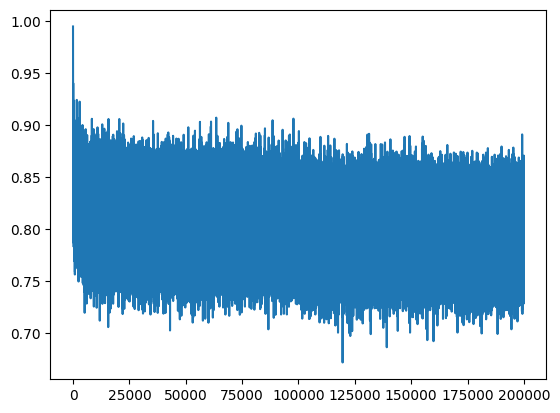

In [79]:
plt.plot(lossi);

In [90]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    # forward pass
    loss = 0 # initialize loss 
    xs, hs, ys = {}, {}, {}
    hs[-1] = torch.zeros(n_hidden).expand(x.shape[0], -1)
    # sequentially iterate over the inputs and update hidden state of RNN each tick
    for t in range(seq_len):
        xs[t] = C[x[:, t]] # Embed input samples (b, n_embed)
        hs[t] = torch.tanh(xs[t]@Wxh + hs[t-1]@Whh + bh) # (b, n_hidden)
        ys[t] = hs[t]@Why + by # (b, n_vocab)
    loss += F.cross_entropy(ys[t], y[:,t])
    print(split, loss.item())
    

split_loss('train')
split_loss('val')

train 2.068574905395508
val 2.114812135696411


In [89]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass
        loss = 0 # initialize loss 
        xs, hs, ps = {}, {}, {}
        hs[-1] = torch.zeros(n_hidden)#.expand(, -1)
        # sequentially iterate over the inputs and update hidden state of RNN each tick
        for t in range(seq_len):
            xs[t] = C[torch.tensor(context[t])] # Embed input samples (b, n_embed)
            hs[t] = torch.tanh(xs[t]@Wxh + hs[t-1]@Whh + bh) # (b, n_hidden)
            ys[t] = hs[t]@Why + by # (b, n_vocab)
            ps[t] = F.softmax(ys[t], dim=0)
        # sample
        ix = torch.multinomial(ps[t], num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carlah.
amberleigh.
mili.
taty.
skanden.
jazhita.
deliah.
jareen.
nellara.
chaiir.
kaleigh.
ham.
jocs.
quinn.
shlin.
alianni.
waterri.
jaristin.
jenni.
sabeed.
